In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  44.7M      0  0:00:17  0:00:17 --:--:-- 40.4M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


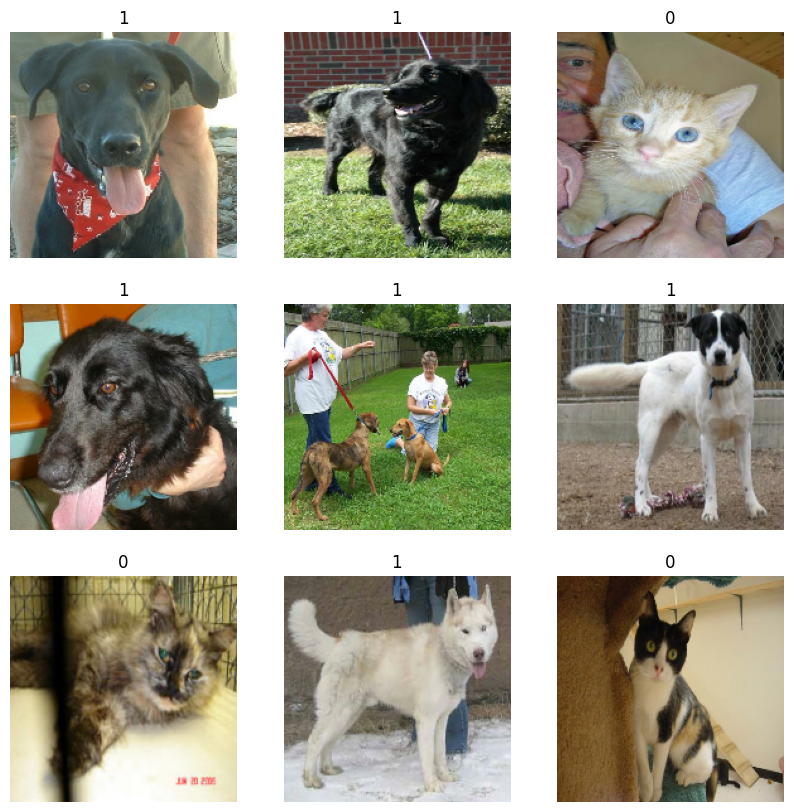

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

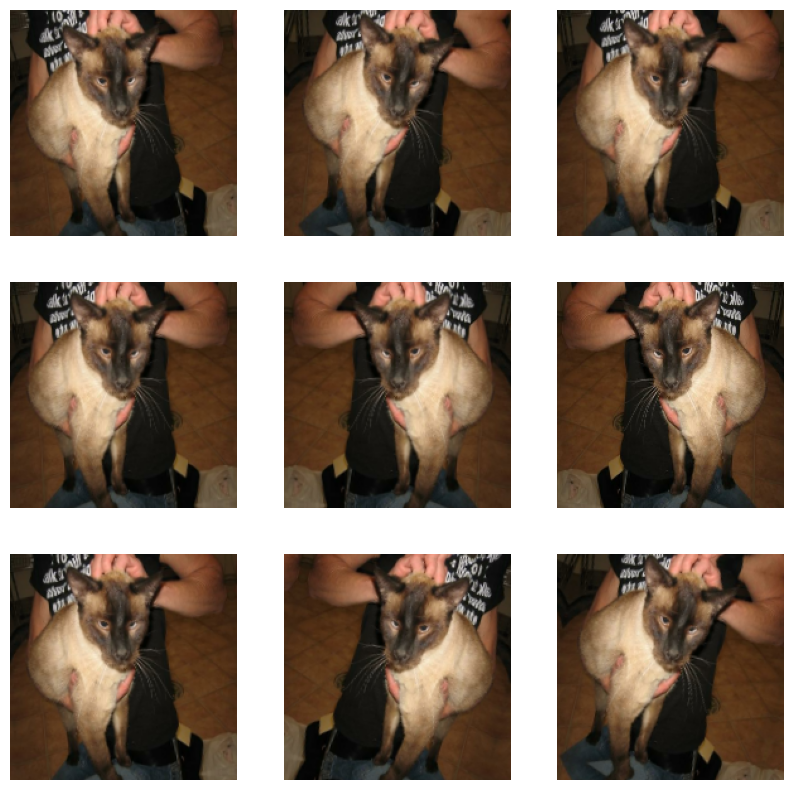

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

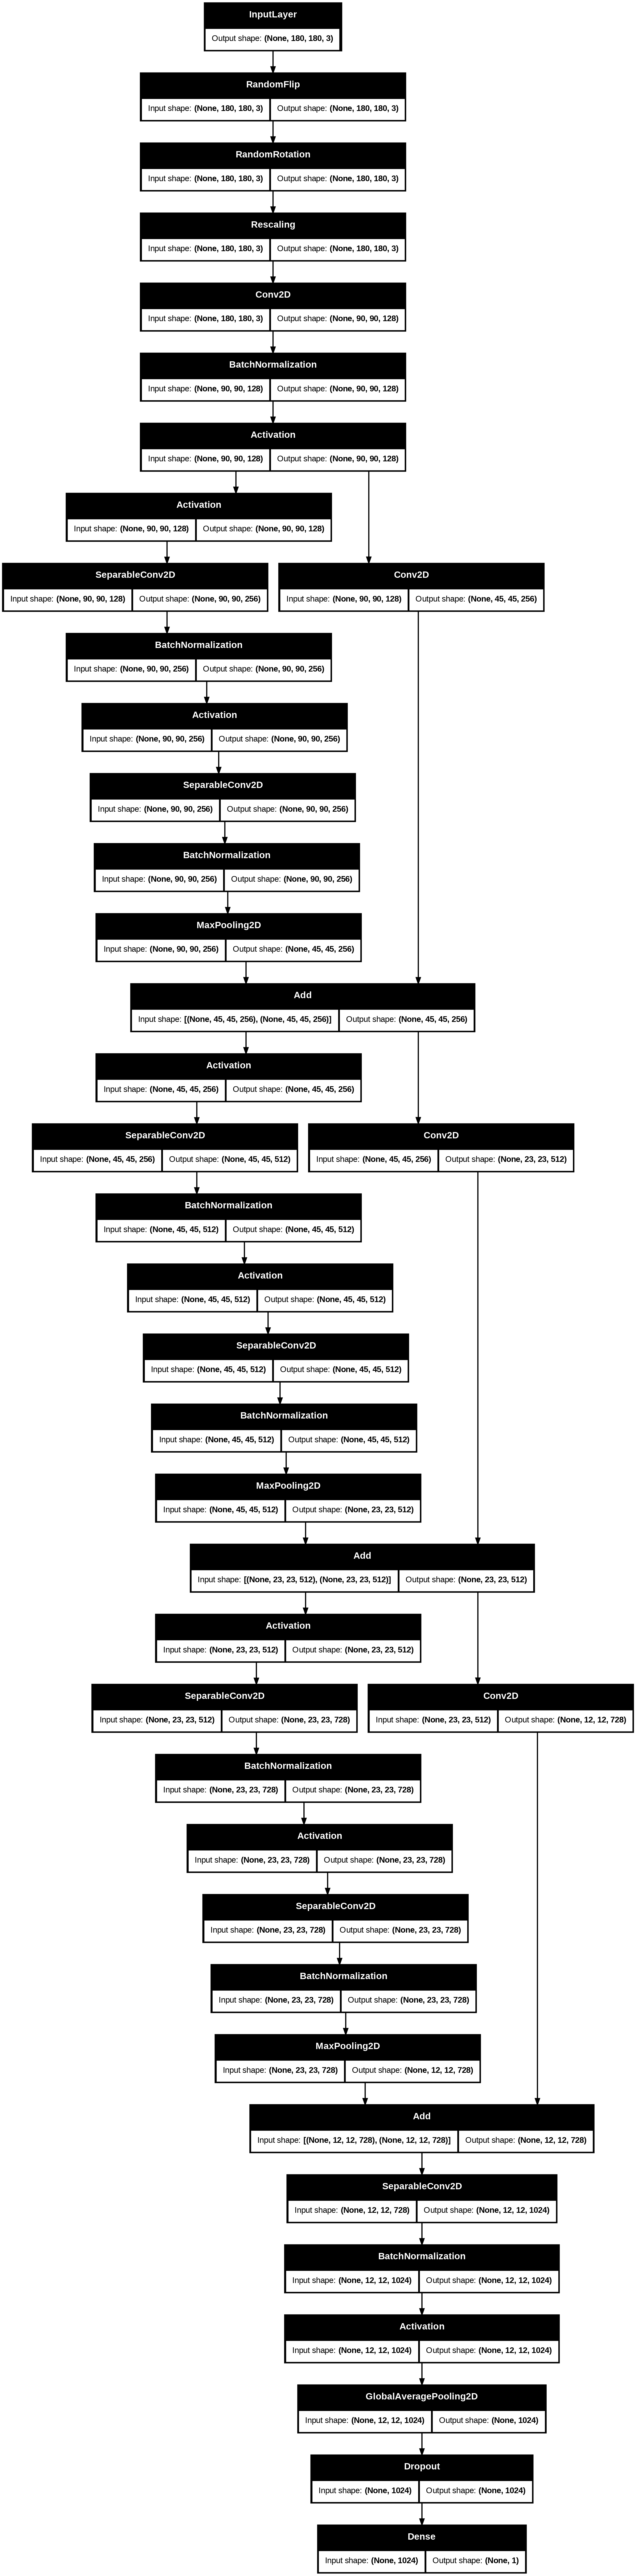

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [12]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - acc: 0.6371 - loss: 0.6301 - val_acc: 0.4957 - val_loss: 0.6966
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - acc: 0.7375 - loss: 0.5109 - val_acc: 0.4957 - val_loss: 0.6917
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - acc: 0.8005 - loss: 0.4156 - val_acc: 0.4957 - val_loss: 0.6897
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - acc: 0.8332 - loss: 0.3553 - val_acc: 0.4972 - val_loss: 0.8099
Epoch 5/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - acc: 0.8646 - loss: 0.3035 - val_acc: 0.6465 - val_loss: 0.5980
Epoch 6/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - acc: 0.8822 - loss: 0.2627 - val_acc: 0.8535 - val_loss: 0.2953
Epoch 7/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - acc: 0.8926 - loss: 0.2392 - val_acc: 0.7984 - val_loss: 0.6729
Epoch 8/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - acc: 0.9069 - loss: 0.2202 - val_acc: 0.8152 - val_loss: 0.3413
Epoch 9/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/

In [13]:
model.save("model.keras")

In [18]:
model=keras.models.load_model("model.keras")
img = keras.utils.load_img("https://unsplash.com/s/photos/cat", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

FileNotFoundError: [Errno 2] No such file or directory: 'https://unsplash.com/s/photos/cat'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
This image is 94.20% cat and 5.80% dog.


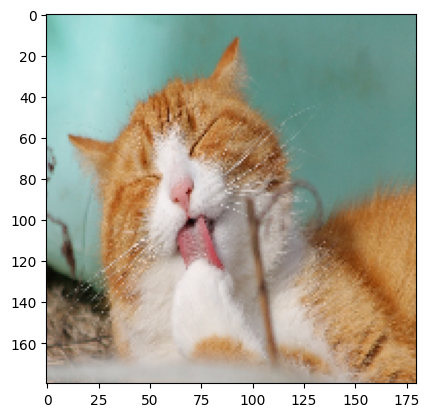

In [26]:
import requests
from io import BytesIO

model = keras.models.load_model("model.keras")

# Replace with a direct link to a cat image
image_url = "https://cdn.pixabay.com/photo/2014/04/13/20/49/cat-323262_1280.jpg"
# Fetch the image from the URL using requests
response = requests.get(image_url, stream=True)
response.raise_for_status()  # Raise an exception for bad responses (like 404)

# Read the content of the response to BytesIO and load the image
img = keras.utils.load_img(BytesIO(response.content), target_size=image_size)

plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")